In [5]:
import pandas as pd
import os

### Prepare data for analys

In [6]:
data = pd.read_csv(filepath_or_buffer='/home/kharlamov/Документы/Project/output/ListProteins.csv')
data = data[data.columns[1:]]

/home/kharlamov/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
data['sum'] = data.loc[:,"freq_A":"freq_X"].sum(axis=1)
data.loc[:,"freq_A":"freq_X"] = data.loc[:,"freq_A":"freq_X"].div(data["sum"], axis=0)
data = data[data.columns[:-1]]

In [8]:
data.to_csv(path_or_buf='/home/kharlamov/Документы/Project/data/ListProteinsFreq.csv')

In [9]:
data.rename(columns={name : name.split('_')[1] for name in list(data.columns[4:])}, inplace = True)

In [148]:
data_tmp = data[data.columns[3:]]
data_tmp[data_tmp.columns[0]] = map(lambda x: 0 if x == 'human' else 1, data_tmp[data_tmp.columns[0]])
data_tmp = data_tmp[data_tmp.columns[:-1]]

In [159]:
labels = map(lambda x: 'human' if x == 1 else 'bacteria or virus', data_tmp['type'])
data_tmp = data_tmp[['type', 'A', 'N', 'C', 'E', 'H', 'L', 'M', 'P', 'T', 'Y', 'R', 'D', 'Q', 'G', 'I', 'K', 'F', 'S', 'W', 'V']]

#### Запуск линейной регрессии и все такое

In [96]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [9]:
data_train, data_test = train_test_split(data_tmp, test_size=0.2)

In [10]:
data_train_x, data_train_y = data_train[data_train.columns[1:]], data_train[data_train.columns[0]]
data_test_x, data_test_y = data_test[data_train.columns[1:]], data_test[data_train.columns[0]]

#### RandomForest

In [13]:
clf = RandomForestClassifier(n_estimators = 100, random_state=14883371)

In [14]:
clf.fit(data_train_x, data_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=14883371, verbose=0,
            warm_start=False)

In [15]:
print('Accuracy on train = ' + str(clf.score(data_train_x, data_train_y)))
print('Accuracyc on test = ' + str(clf.score(data_test_x, data_test_y))) # Перебрал по сетке, базовые параметры практически выдали лучший скор

Accuracy on train = 0.9999882682809512
Accuracyc on test = 0.9013608634443923


In [16]:
clf.feature_importances_ # Видно, что в среднем все аминокислоты дают равный вклад

array([1.06005588e-01, 6.65275553e-06, 1.03865202e-01, 4.32493511e-02,
       3.70386328e-02, 2.75628408e-02, 3.00065637e-02, 2.83710533e-02,
       1.15402507e-01, 0.00000000e+00, 5.26282085e-02, 2.63091107e-02,
       2.58992507e-02, 4.07543529e-02, 0.00000000e+00, 7.70046389e-02,
       3.41080754e-02, 3.41251647e-02, 9.00059100e-02, 2.96640104e-02,
       1.54535873e-05, 4.15628718e-02, 2.51676647e-02, 3.12468956e-02,
       0.00000000e+00])

In [17]:
y_pred = clf.predict(data_test_x)
print('F1 Score = ' + str(f1_score(y_pred, data_test_y)))

F1 Score = 0.8189803651395109


In [18]:
print('ROC AUC = ' + str(roc_auc_score(y_pred, data_test_y)))

ROC AUC = 0.9047084167340971


In [19]:
score_cross_val = cross_val_score(clf, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=-1)

array([0.83219461, 0.89638862, 0.88565208, 0.89353555, 0.90081838,
       0.91808079, 0.92003304, 0.89908395])

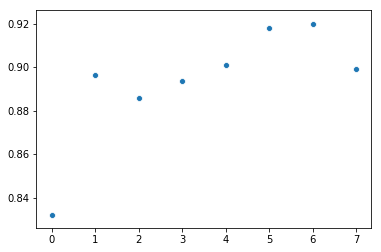

In [20]:
sns.scatterplot(x = [i for i in range(len(score_cross_val))], y = score_cross_val)
score_cross_val #Видно, что в среднем на кросс валидации результат около 90%

### Logistic Regression

In [35]:
clf_2 = LogisticRegression(max_iter=10**6, C=10000) # Регулиризация была настроена по gridsearch'у

In [37]:
cross_val_score(clf_2, data_tmp[data_tmp.columns[1:]],data_tmp['type'], cv = 8, n_jobs=-1).mean() 
# Видно, что с RF разница 8%

0.8275634419893712

In [12]:
#Попробуем улучшить результат путем PolynominalFeauture.
data_y = data_tmp['type']
data_x = data_tmp[data_tmp.columns[1:]]
Poly = PolynomialFeatures(degree=2)

In [13]:
data_poly_transform = pd.DataFrame(Poly.fit_transform(data_x, data_y))
data_poly_transform = data_poly_transform[data_poly_transform.columns[1:]]

In [14]:
data_poly_transform.head()

,1,2,3,4,5,6,7,8,9,10,...,341,342,343,344,345,346,347,348,349,350
0,0.055072,0.0,0.075362,0.060870,0.046377,0.034783,0.084058,0.031884,0.040580,0.0,...,0.004839,0.001210,0.002621,0.0,0.000302,0.000655,0.0,0.001420,0.0,0.0
1,0.092025,0.0,0.018405,0.036810,0.055215,0.036810,0.116564,0.024540,0.018405,0.0,...,0.007377,0.002108,0.002635,0.0,0.000602,0.000753,0.0,0.000941,0.0,0.0
2,0.046875,0.0,0.000000,0.015625,0.046875,0.093750,0.000000,0.015625,0.015625,0.0,...,0.024414,0.000000,0.004883,0.0,0.000000,0.000000,0.0,0.000977,0.0,0.0
3,0.058559,0.0,0.018018,0.018018,0.031532,0.040541,0.072072,0.022523,0.067568,0.0,...,0.006574,0.002191,0.002191,0.0,0.000730,0.000730,0.0,0.000730,0.0,0.0
4,0.043636,0.0,0.018182,0.029091,0.025455,0.032727,0.043636,0.069091,0.061818,0.0,...,0.004774,0.001507,0.003517,0.0,0.000476,0.001111,0.0,0.002592,0.0,0.0


In [16]:
clf_3 = LogisticRegression(max_iter=10**6, C=10000)

In [17]:
cross_val_score(clf_3, data_poly_transform, data_y, cv = 3) # Видно, что стало лучше, но до RF еще далеко

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.84185038, 0.83897398, 0.89052821])

### Others

In [40]:
pca = PCA(n_components=3)
data_tmp_pca = pd.DataFrame(pca.fit_transform(data_poly_transform))
data_tmp_pca.tail()

,0,1,2
106544,0.040460,-0.004320,0.061092
106545,0.081714,0.004064,-0.013576
106546,0.019030,0.001104,0.058905
106547,0.013980,-0.018033,0.056140
106548,-0.039115,-0.014884,0.023004


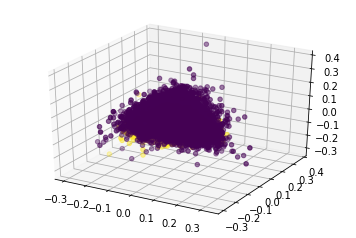

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca[0], data_tmp_pca[1], data_tmp_pca[2], c = labels)

In [49]:
pca = PCA(n_components=3)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
data_tmp_pca_2.tail()

,0,1,2
106544,0.025232,0.013911,0.066532
106545,0.075349,-0.025712,-0.094151
106546,-0.001868,0.017161,0.025876
106547,-0.006454,0.038494,0.000726
106548,-0.036305,0.027254,0.001370


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], data_tmp_pca_2[2], c = labels)
for ii in range(0,360,30):
        ax.view_init(elev=10., azim=ii)
        plt.savefig("movie%d.png" % ii)

MemoryError: 

Error in callback <function post_execute at 0x7f19d369e0c8> (for post_execute):


MemoryError: 

# Настраиваемые кривые валидации для RFC

In [151]:
X, y = data_tmp[data_tmp.columns[1:]], data_tmp['type']

In [18]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]
# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 90.13% with 100 trees


Text(0.5,0,'N_estimators')

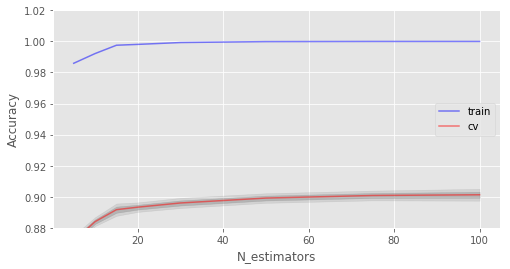

In [19]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

In [20]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=60, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100, 
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 89.97% with 24 max_depth


Text(0.5,0,'Max_depth')

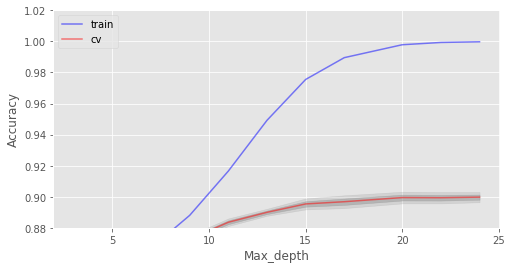

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

In [23]:
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=60, max_depth=20, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100, 
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 89.95% with 1 min_samples_leaf


Text(0.5,0,'Min_samples_leaf')

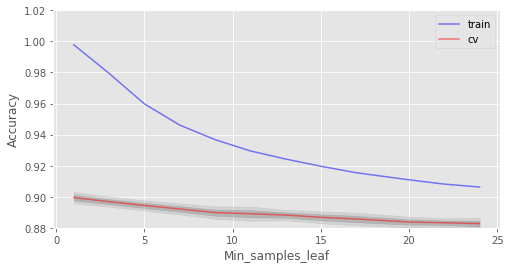

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

In [27]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=60, max_depth=20, min_samples_leaf=20, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100, 
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 88.50% with 8 max_features


Text(0.5,0,'Max_features')

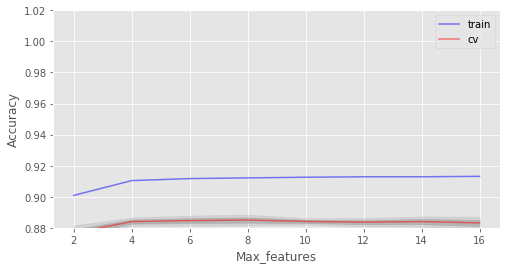

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

In [152]:
rfc = RandomForestClassifier(n_estimators=60, max_depth=20, min_samples_leaf=20, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=8)
rfc.fit(X,y)
cross_val_score(rfc, X, y)

array([0.83928823, 0.84632278, 0.88295416])

# Осмотр данных

Text(0.5,0,'PCA_3')

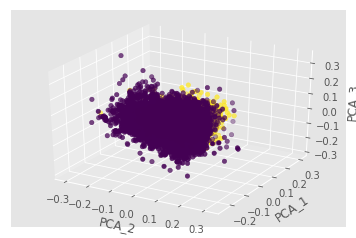

In [45]:
pca = PCA(n_components=3)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], data_tmp_pca_2[2], c = labels)
ax.set_ylabel("PCA_1")
ax.set_xlabel("PCA_2")
ax.set_zlabel('PCA_3')

Text(0.5,0,'PCA_2')

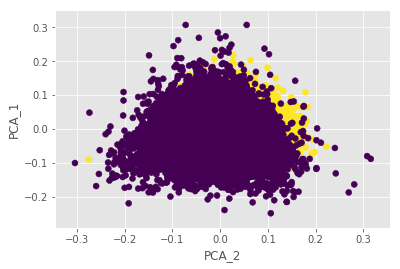

In [44]:
pca = PCA(n_components=2)
data_tmp_1, data_tmp_2 = train_test_split(data_tmp[data_tmp.columns[1:]], test_size = 0.99)
data_tmp_pca_2 = pd.DataFrame(pca.fit_transform(data_tmp[data_tmp_1.columns[1:]]))
fig, ax = plt.subplots()
ax.scatter(data_tmp_pca_2[0], data_tmp_pca_2[1], c = labels, )
ax.set_ylabel("PCA_1")
ax.set_xlabel("PCA_2")

<BarContainer object of 20 artists>

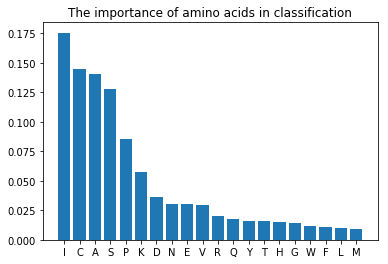

In [153]:
aminoacid = list('ANCEHLMPTYRDQGIKFSWV')
aminoacid_freq = rfc.feature_importances_
B = zip(aminoacid, aminoacid_freq)
B.sort(key = lambda x: x[1], reverse=True)
aminoacid = map(lambda x: x[0], B)
aminoacid_freq = map(lambda x: x[1], B)
plt.title('The importance of amino acids in classification')
plt.bar(aminoacid, aminoacid_freq)

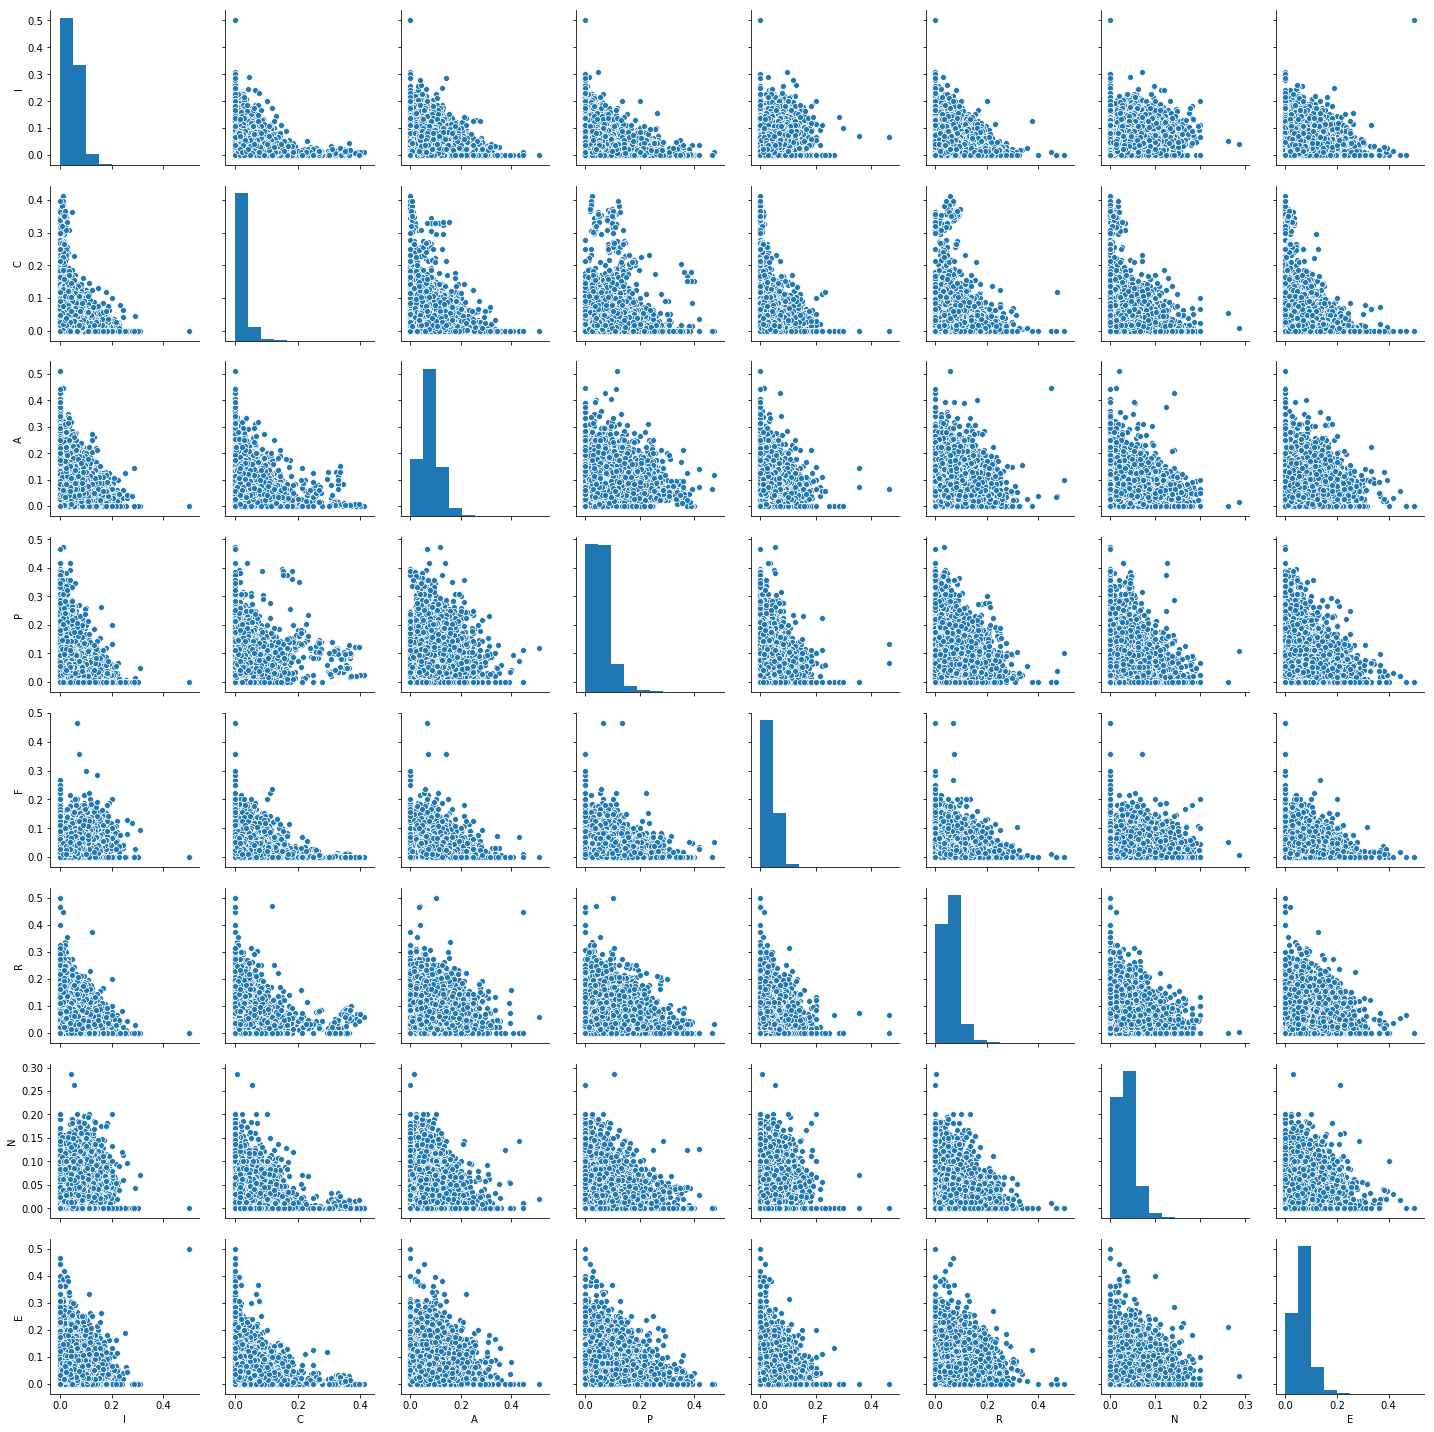

In [154]:
sns.pairplot(data_tmp[['I', 'C', 'A', 'P', 'F', 'R', 'N', 'E']])

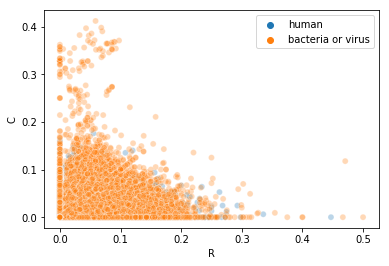

In [162]:
sns.scatterplot(data_tmp['R'], data_tmp['C'], hue = labels, alpha=0.3)